# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# General packages
import zipfile
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import sklearn.metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.ensemble import RandomForestClassifier

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


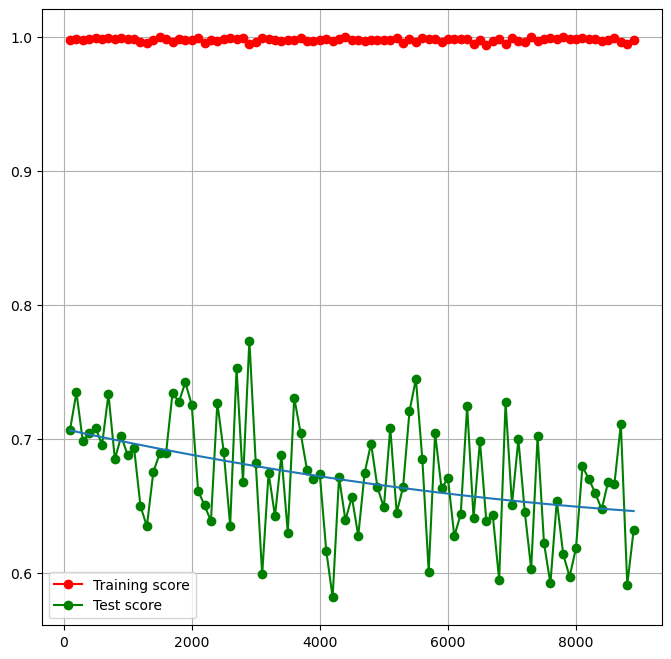

In [ ]:
# Deze code maakt een grafiek waarin met een simpele random forest verschillende aantal features plot voor een train-test-split
# om zo te kijken hoeveel features we ongeveer willen selecteren voor het echte model

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)
for k in k_list:
    rf = Pipeline([('feature_selection', SelectKBest(f_classif, k=k)), ('rfc', RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=42))])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.legend()


In [64]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 2000, 100), #[300, 400, 500, 9000],
        'classifier__n_estimators': np.arange(10, 100, 5), #[30, 40, 50],
        'classifier__min_samples_split': np.arange(2, 20, 2), #[5, 10, 15],
        'classifier__max_depth': [5, 10, 15, None], #[5, 10, 15, None],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                                pipe, 
                                                param_distributions=param_dist, 
                                                cv=StratifiedKFold(n_splits=5), 
                                                n_iter=n_iterations,
                                                scoring='roc_auc', 
                                                n_jobs=-1
                                                )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

Best Parameters: {'feature_selection__k': 400, 'classifier__n_estimators': 70, 'classifier__min_samples_split': 2, 'classifier__max_depth': 15, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.8177361853832442
Best Parameters: {'feature_selection__k': 700, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 16, 'classifier__max_depth': None, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.8245503497074027
Best Parameters: {'feature_selection__k': 200, 'classifier__n_estimators': 75, 'classifier__min_samples_split': 14, 'classifier__max_depth': None, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7926130028357328
Best Parameters: {'feature_selection__k': 500, 'classifier__n_estimators': 95, 'classifier__min_samples_split': 14, 'classifier__max_depth': 15, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.8194019002128654


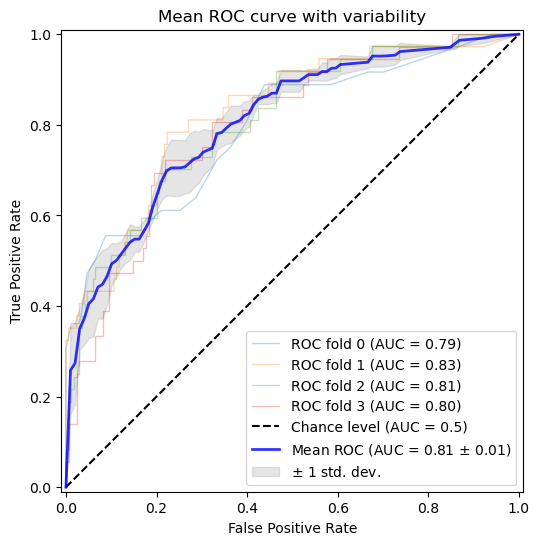

In [65]:
random_state = np.random.RandomState(0)

y = data.iloc[:,-1]
X = data.iloc[:,:-1]

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
best_classifier = None
best_auc = 0.0
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    classifier = optimize_rf(X_train, y_train)
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    if viz.roc_auc > best_auc:
        best_auc = viz.roc_auc
        best_classifier = classifier

    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    fold_auc = roc_auc_score(y_test, y_proba)

    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"AUC Score: {fold_auc:.3f}")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')